# Test model performance on adhesin motifs not previously encountered

### Count sequences per category

In [1]:
from Bio import SeqIO
import os
import copy

ADH_60 = './data/60_similarity/positive/adhesins.fasta'
ADH_25 = './data/25_similarity/positive/adhesins.fasta'


In [2]:
# initiate dictionaries with all sequences from all motifs
sequence_dictionary_60 = {}
dir_ = './data/raw_sequences/'
for file in os.listdir(dir_):
    if len(file) < 11:
        motif_name = file.split('.')[0]
        motif_sequences = list(SeqIO.parse(os.path.join(dir_, file), 'fasta'))
        sequence_dictionary_60[motif_name] = {seq.id:0 for seq in motif_sequences}
sequence_dictionary_25 = copy.deepcopy(sequence_dictionary_60)

In [3]:
# fill dictionaries
adh_25_sequences = list(SeqIO.parse(ADH_25, 'fasta'))
for seq in adh_25_sequences:
    for motif in sequence_dictionary_25:
        if seq.id in sequence_dictionary_25[motif]:
            sequence_dictionary_25[motif][seq.id] = 1
            
adh_60_sequences = list(SeqIO.parse(ADH_60, 'fasta'))
for seq in adh_60_sequences:
    for motif in sequence_dictionary_60:
        if seq.id in sequence_dictionary_60[motif]:
            sequence_dictionary_60[motif][seq.id] = 1

In [4]:
# count
print('Protein count per motif at 60% and 25% cleaning:')
for motif in sequence_dictionary_25:
    count_60 = sum(sequence_dictionary_60[motif].values())
    count_25 = sum(sequence_dictionary_25[motif].values())
    print(f'{motif} {count_60} {count_25}')

Protein count per motif at 60% and 25% cleaning:
PF08363 44 15
PF05737 484 153
PF08829 2 2
PF18220 7 5
PF17480 1 1
PF12799 5932 1719
PF18573 313 158
PF03212 431 136
PF07979 1 1
PF02216 5 4
PF15403 1 1
PF18651 121 37
PF05658 1299 414
PF08341 409 129
PF07675 288 76
PF18304 5 1
PF09160 20 5
PF18652 73 22
PF09403 16 10
PF18873 6 2
PF18483 491 234
PF10425 48 33
PF11966 7 1
PF15401 7 5
PF07691 2089 569


### Asses model perfomance on different datasets

In [6]:
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

In [7]:
def from_files_to_vectors(fasta_path, motif='', motif_dictionary=sequence_dictionary_25, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'adhesins.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'non_adhesins.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    motif_datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                # place proteins with a given motif in a specific dataset
                if positive:
                    if information[0] in motif_dictionary[motif].keys():
                        motif_datasets[i].append(np.array([float(el) for el in information[1:]]))
                    else:
                        datasets[i].append(np.array([float(el) for el in information[1:]]))
                else:    
                    datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
        if positive:
            motif_datasets[i] = np.array(motif_datasets[i])
    if positive:
        
        return datasets, motif_datasets
    return datasets

In [8]:
from tensorflow.keras import regularizers
import pandas as pd

class neural_network:
    def __init__(self, K):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=10, 
                                                activation='sigmoid',
                                                kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                bias_regularizer=regularizers.L2(1e-3),
                                                activity_regularizer=regularizers.L2(1e-3))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(.1)(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model


def run_model_motifs(pos_datasets, neg_datasets, motif_datasets, projection_matrix='projection_matrix.npy',\
                    model_weights = 'ac_motif.h5', training_means = np.load('./mean.npy'), \
                    training_std_devs = np.load('./std.npy')):
    """Run multiple cross validations over different motifs to test model generalization"""
    
    # pre processing
    y_pos = np.ones(pos_datasets[0].shape[0])
    y_neg = np.zeros(neg_datasets[0].shape[0])
    y_motif = np.ones(motif_datasets[0].shape[0])
    
    # attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features
    rows = 0
    n_pos = y_pos.shape[0]
    n_neg = y_neg.shape[0]
    rows = n_pos + n_neg
    # feature vectors dimensions
    columns = 0
    for i in range(len(pos_datasets)):
        tmp_dim = pos_datasets[i].shape[1]
        columns += tmp_dim
    # data matrix to process
    X = np.zeros((rows, columns))
    for i in range(n_pos):
        X[i] = np.concatenate([pos_datasets[j][i] for j in range(5)])
    for i in range(n_neg):
        X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(5)])
    # same for motif dataset
    X_motifs = np.zeros((y_motif.shape[0], columns))
    for i in range(y_motif.shape[0]):
        X_motifs[i] = np.concatenate([motif_datasets[j][i] for j in range(5)])
    
    # permutation
    np.random.seed(42)
    y = np.concatenate((y_pos, y_neg), axis=0)
    c = np.random.permutation(np.arange(y.shape[0]))
    y = y[c]
    X = X[c] 
    
    # split datasets for training 
    X_train = X[:int(X.shape[0]*.5)]
    X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
    X_test = X[int(X.shape[0]*.75):]

    y_train = y[:int(y.shape[0]*.5)]
    y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
    y_test = y[int(y.shape[0]*.75):]
    
    # standardize
    def standardize(dataset):
        """Standardize dataset"""
        std_dataset = np.zeros(dataset.shape)
        for j in range(dataset.shape[1]):
            column = dataset[:,j]
            std_dataset[:,j] = (column - training_means[j]) / training_std_devs[j]
        return std_dataset
    
    stdX = standardize(X_train)
    stdX_val = standardize(X_val)    
    stdX_test = standardize(X_test)    
    stdX_motif = standardize(X_motifs)
    
    # project matrices
    projection_matrix = np.load(projection_matrix)
    X_train = stdX.dot(projection_matrix)
    X_val = stdX_val.dot(projection_matrix)
    X_test = stdX_test.dot(projection_matrix)
    X_motif = stdX_motif.dot(projection_matrix)
    
    # initiate model
    nn = neural_network(400)
    # train
    history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=0,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=5
        )])
    
    model_test = nn.model.evaluate(x=X_test, y=y_test)
    print(model_test)
    nn.model.save('ac_motif.h5')
    model = tensorflow.keras.models.load_model(model_weights)
    motif_test = model.evaluate(x=X_motif, y=y_motif)
    print(motif_test)
    return model_test, motif_test

In [10]:
outlist = []
for motif in sequence_dictionary_25:
    pos_datasets, motif_datasets = from_files_to_vectors("./data/25_similarity/positive/", motif, positive=True)
    neg_datasets = from_files_to_vectors("./data/25_similarity/negative/", positive=False)
    #print(motif, sum(sequence_dictionary_25[motif].values()))
    model_test, motif_test = run_model_motifs(pos_datasets, neg_datasets, motif_datasets)
    outlist.append([motif, sum(sequence_dictionary_25[motif].values()), model_test[1],\
                    motif_test[1]])

2022-11-24 13:26:47.913347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-24 13:26:47.913490: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 13:26:47.913520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ad383b76f2b6): /proc/driver/nvidia/version does not exist
2022-11-24 13:26:47.913836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58/58 [==============================] - 0s 1ms/step - loss: 0.2316 - accuracy: 0.9369
[0.23156243562698364, 0.936859130859375]
1/1 [==============================] - 0s 179ms/step - loss: 0.4061 - accuracy: 0.9333
[0.40609607100486755, 0.9333333373069763]
57/57 [==============================] - 0s 1ms/step - loss: 0.2371 - accuracy: 0.9312
[0.237071692943573, 0.9312431216239929]
5/5 [==============================] - 0s 2ms/step - loss: 0.1551 - accuracy: 0.9673
[0.15505166351795197, 0.9673202633857727]
58/58 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.9429
[0.2085108608007431, 0.9428879022598267]
1/1 [==============================] - 0s 176ms/step - loss: 0.0664 - accuracy: 1.0000
[0.06643704324960709, 1.0]
58/58 [==============================] - 0s 826us/step - loss: 0.2162 - accuracy: 0.9445
[0.21620430052280426, 0.9444743990898132]
1/1 [==============================] - 0s 104ms/step - loss: 1.1477 - accuracy: 0.4000
[1.1476943492889404, 0.400000

In [14]:
df = pd.DataFrame(outlist, columns = ['motif', 'proteins', 'model_accuracy', 'model_accuracy_on_motif'])
print(f'The mean accuracy on unseen adhesin motifs is {df["model_accuracy_on_motif"].mean()}')
df

The mean accuracy on unseen adhesin motifs is 0.8097682595252991


,motif,proteins,model_accuracy,model_accuracy_on_motif
0,PF08363,15,0.936859,0.933333
1,PF05737,153,0.931243,0.967320
2,PF08829,2,0.942888,1.000000
3,PF18220,5,0.944474,0.400000
4,PF17480,1,0.939655,1.000000
5,PF12799,1719,0.946741,0.391507
6,PF18573,158,0.944964,0.841772
7,PF03212,136,0.930845,0.955882
8,PF07979,1,0.939655,1.000000
9,PF02216,4,0.939084,0.250000


<AxesSubplot: >

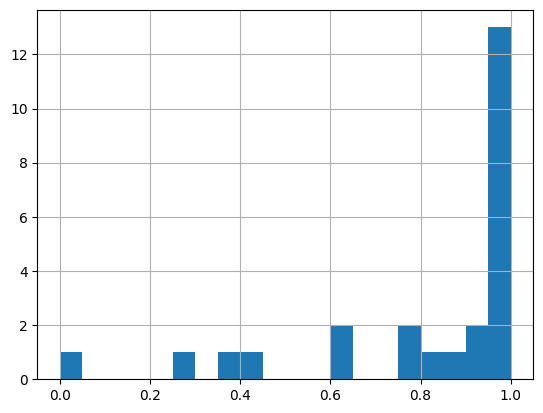

In [16]:
df['model_accuracy_on_motif'].hist(bins=20)